# 2. Chebyshev Spectral Grid

In [1]:
import numpy as np
from scipy.special import erf

from scipy.linalg import inv
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

In [2]:
N = 16 # Here n can be either even or odd

def is_the_same(A, B):
    return np.max(np.abs(A - B)) < 1e-6

row = np.arange(N + 1)[:, None]
col = np.arange(N + 1)[None, :]

angular_spectral_grid = np.pi * row / N
spectral_grid         = np.cos(angular_spectral_grid)
angular_dense_grid    = np.linspace(0, np.pi, 1000)[:, None]
dense_grid            = np.cos(angular_dense_grid)

spectral_basis = np.cos(col * angular_spectral_grid)
dense_basis    = np.cos(col * angular_dense_grid)

## 2.1 Chebyshev polynomials and the Nyquist frequency

Some text here

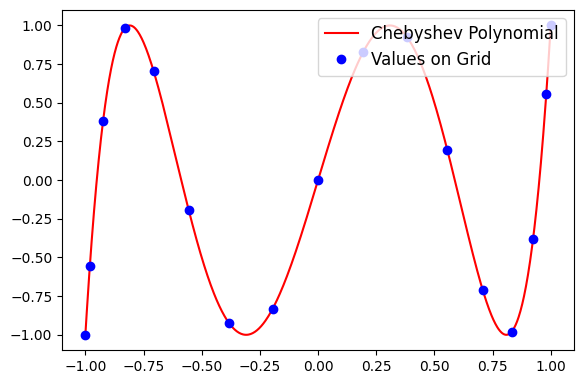

In [3]:
n = 5   # Try the Nyquist frequency n = N

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    dense_basis[:, n], 'r-', label = 'Chebyshev Polynomial')
ax.plot(spectral_grid, spectral_basis[:, n], 'bo',  label = 'Values on Grid')
ax.legend(loc = 'upper right')
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 2.2 Orthogonality

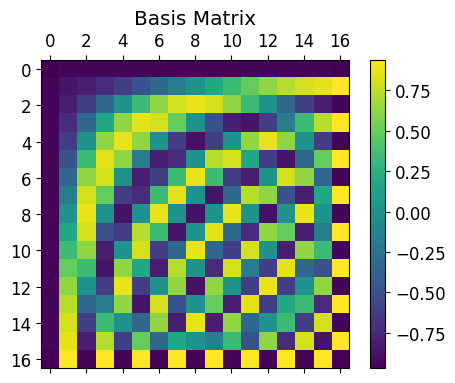

In [4]:
################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1, 1, figsize = (5, 4));
plt.rc('font', size = 12)

ax.set_title('Basis Matrix')
pt0 = ax.matshow(inv(spectral_basis) - spectral_basis)
plt.colorbar(pt0, ax = ax)

plt.tight_layout()
################################################################################

True


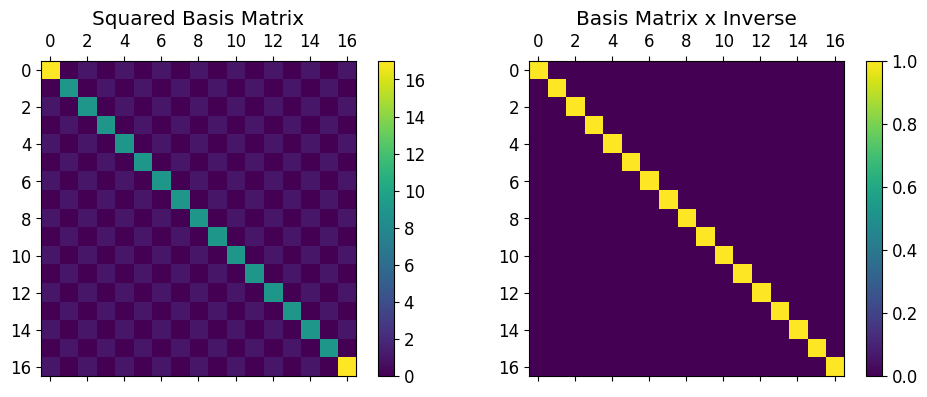

In [5]:
c = 1 + (col % N == 0)
c = 2 / (c.T @ c)
spectral_basis_inv = spectral_basis * (c / N)

print(is_the_same(spectral_basis_inv, inv(spectral_basis)))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('Squared Basis Matrix')
pt0 = ax[0].matshow(spectral_basis @ spectral_basis)
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('Basis Matrix x Inverse')
pt1 = ax[1].matshow(spectral_basis @ spectral_basis_inv)
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

## 2.3  The cardinal polynomials

True


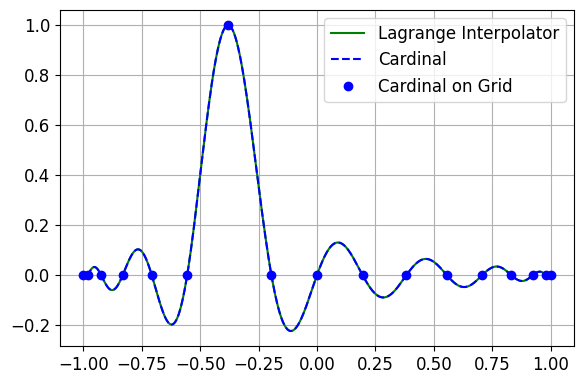

In [6]:
n = 10

def LagrangeInterpolator(x, j, spectral_grid):
    numerator = (x- spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) / np.prod(denominator)

spectral_cardinals = np.eye(N + 1)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(is_the_same(LagrangeInterpolator(dense_grid, n, spectral_grid), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeInterpolator(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Interpolator')
ax.plot(dense_grid,    dense_cardinals[:, n], 'b--', label = 'Cardinal')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

True


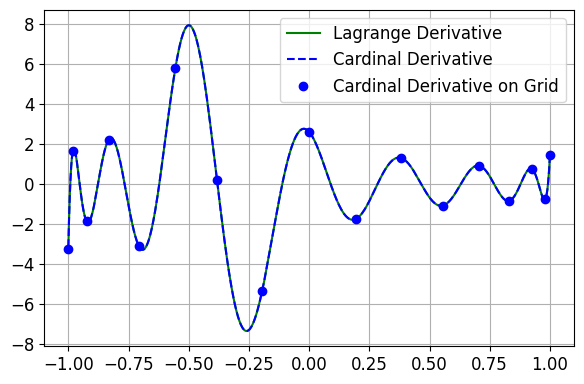

In [7]:
n = 10

def LagrangeDerivative(x, j, spectral_grid):
    epsilon = 1e-15
    numerator = (x + epsilon - spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) * (np.sum(1/numerator, axis = 0) - 1) / np.prod(denominator)

spectral_basis_diff = col * np.sin(col * angular_spectral_grid[1:-1]) / np.sqrt( 1 - np.cos(angular_spectral_grid[1:-1])**2 )
dense_basis_diff    = col * np.sin(col * angular_dense_grid[1:-1]) / np.sqrt( 1 - np.cos(angular_dense_grid[1:-1])**2 )
spectral_basis_diff = np.concatenate([col**2, spectral_basis_diff, - (-1)**col * col**2], axis = 0)
dense_basis_diff    = np.concatenate([col**2, dense_basis_diff   , - (-1)**col * col**2], axis = 0)

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(is_the_same(LagrangeDerivative(dense_grid, n, spectral_grid), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeDerivative(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Derivative')
ax.plot(dense_grid, dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 2.4 Chebyshev Differentiation Matrices and Interpolation

In [8]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

x, D1, D2 = ChebyshevD(N)
is_the_same(D1, diff_matrix)

True

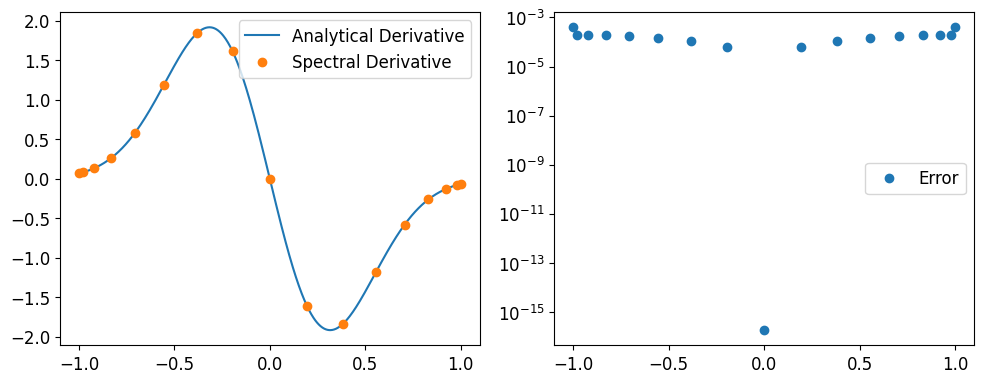

In [9]:
f  = np.exp( -5 * x**2 )
df = -10 * x * np.exp( -5 * x**2 )

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals @ df, label = 'Analytical Derivative')
ax[0].plot(x, D1 @ f, 'o', label = 'Spectral Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(D1 @ f - df), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 2.5 Chebyshev FFT Differentiation

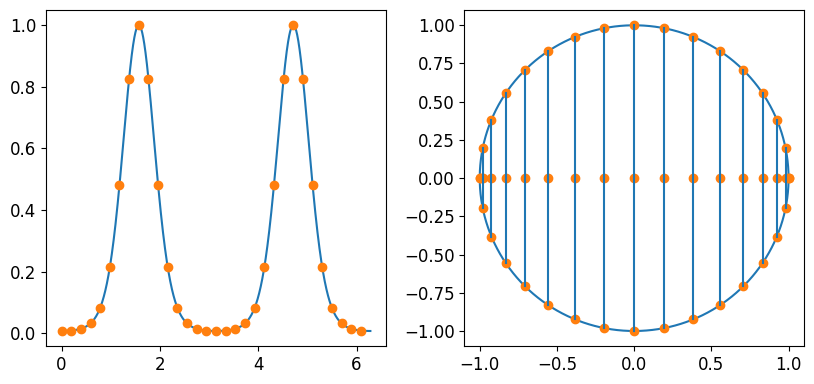

In [10]:
f  = np.exp( -5 * x**2 )
df = -10 * x * np.exp( -5 * x**2 )

long_f             = np.concatenate([f, f[-2:0:-1, :]])
long_spectral_grid = np.concatenate([angular_spectral_grid, angular_spectral_grid[1:-1, :] + np.pi])
long_dense_f       = np.concatenate([(dense_cardinals @ f), (dense_cardinals @ f)[-2:0:-1, :]])
long_dense_grid    = np.concatenate([angular_dense_grid, angular_dense_grid[1:-1, :] + np.pi])

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (8.3, 4));
plt.rc('font', size = 12)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax[0].plot(long_dense_grid, long_dense_f)
ax[0].plot(long_spectral_grid, long_f, 'o')

ax[1].plot(np.cos(long_dense_grid), np.sin(long_dense_grid))
ax[1].plot(np.cos(long_spectral_grid), np.sin(long_spectral_grid), 'o')
ax[1].plot(spectral_grid, np.zeros(N+1), 'o', color = colors[1])
[ax[1].plot([line, line], [-np.sqrt(1-line**2), np.sqrt(1-line**2)], color = colors[0]) for line in spectral_grid]

plt.tight_layout()
################################################################################


The frequencies we are considering are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15   0 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1].
Notice we have removed the asymetric Nyquist mode.



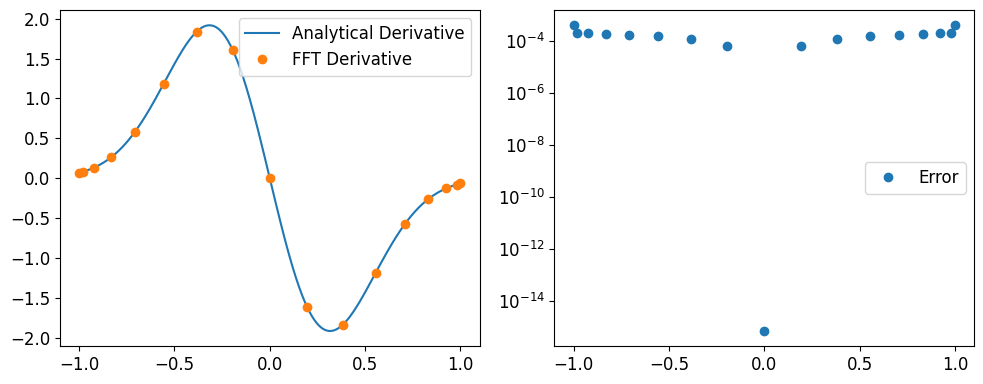

In [11]:
def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

freqs    = aliased_index(np.arange(2 * N), 2 * N) 
freqs[N] = 0    #This is equivalent to Trefethen's trick in page 78.

long_fft  = fft(long_f.flatten()).real 
long_ifft = ifft(1j * freqs * long_fft).real

FFT_df      = np.zeros(N + 1)
ind         = np.arange(N)
FFT_df[1:N] = - long_ifft[1:N] / np.sqrt(1 - x[1:-1, 0].flatten()**2)
FFT_df[0]   = np.sum(ind**2 * long_fft[:N]) / N + 0.5 * N * long_fft[N]
FFT_df[N]   = np.sum((-1)**(ind + 1) * ind**2 * long_fft[:N]) / N + 0.5 * (-1)**(N+1) * N * long_fft[N]
    
print(f'\nThe frequencies we are considering are: {freqs}.')
print(f'Notice we have removed the asymetric Nyquist mode.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals @ df, label = 'Analytical Derivative')
ax[0].plot(x, FFT_df, 'o', label = 'FFT Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(FFT_df - df.flatten()), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 2.6 The Clenshaw-Curtis quadrature and integration

In [12]:
c      = N * (1 + (row % N == 0))
fft_an = long_fft[:N+1, None] / c

is_the_same(fft_an, spectral_basis_inv @ f)

True

In [13]:
CorrectIntegral        = 0.79142461922102708410
ClenshawCurtisIntegral = np.sum(2 * fft_an[::2] / (1 - row[::2]**2))

is_the_same(CorrectIntegral, ClenshawCurtisIntegral)

True

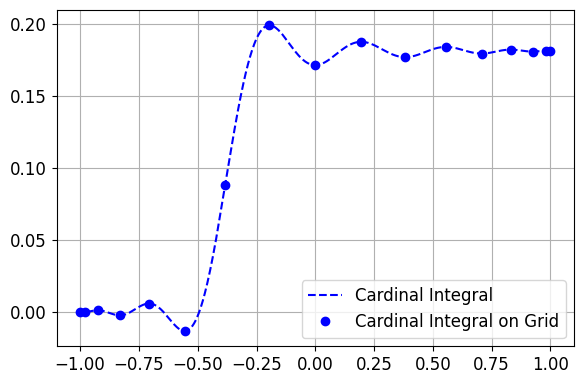

In [14]:
n = 10

scol = col[:, 2:]

spectral_basis_int  = scol * np.cos((scol + 1) * angular_spectral_grid) / (scol**2 - 1) - \
                      np.cos(angular_spectral_grid) * np.cos(scol * angular_spectral_grid) / (scol - 1)
spectral_basis_int  = np.concatenate([spectral_grid, spectral_grid**2 / 2, spectral_basis_int], axis = 1)
spectral_basis_int -= spectral_basis_int[[-1], :]

dense_basis_int  = scol * np.cos((scol + 1) * angular_dense_grid) / (scol**2 - 1) - \
                   np.cos(angular_dense_grid) * np.cos(scol * angular_dense_grid) / (scol - 1)
dense_basis_int  = np.concatenate([dense_grid, dense_grid**2 / 2, dense_basis_int], axis = 1)
dense_basis_int -= dense_basis_int[[-1], :]

int_matrix          = spectral_basis_int @ spectral_basis_inv
dense_cardinals_int = dense_basis_int @ spectral_basis_inv

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, dense_cardinals_int[:, n].real, 'b--', label = 'Cardinal Integral')
ax.plot(spectral_grid, int_matrix[:, n].real, 'bo', label = 'Cardinal Integral on Grid')
ax.legend(loc = 'lower right')
ax.grid()

plt.tight_layout()
################################################################################

True


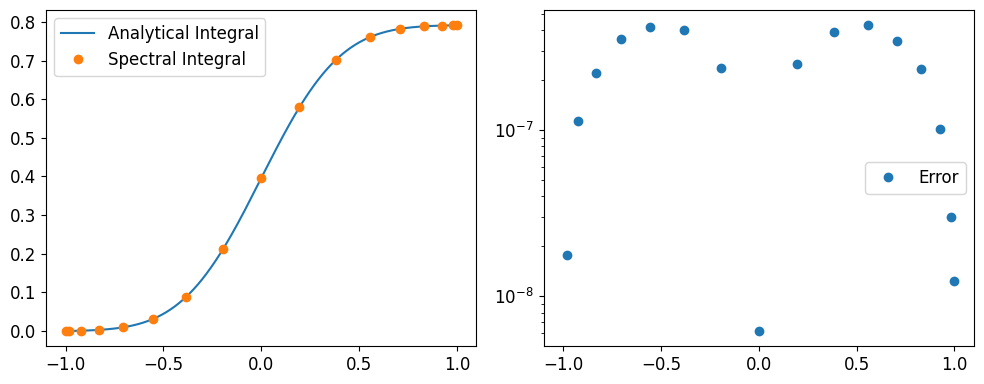

In [15]:
f  = np.exp( -5 * x**2 )
int_f  = 0.5 * np.sqrt(np.pi / 5) * erf(np.sqrt(5) * x)
int_f -= int_f[-1]

print(is_the_same(int_f[0], CorrectIntegral))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ int_f, label = 'Analytical Integral')
ax[0].plot(x, int_matrix @ f, 'o', label = 'Spectral Integral')
ax[0].legend(loc = 'upper left')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(int_matrix @ f - int_f), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################